# Conducting NBRA-based nonadiabatic dynamics


## Table of contents
<a name="toc"></a>

1. [Importing Libra and other dependencies](#import)  
2. [Read in the Kohn-Sham data](#read)  
   2.1. [Check data retrieval](#sanity_ks)  
   2.2. [Compute decoherence time in Kohn-Sham basis](#decoherence)        
3. [Setup NBRA NAMD calculations](#setup)  
4. [Hot electron cooling](#electron)  
   4.1. [NBRA FSSH](#nbra_fssh)  
   4.2. [Decoherence methods](#decoherence_cooling) | [Exercise1](#exercise1)  
   4.3. [BLLZ NAMD](#bllz)  
5. [LUMO-HOMO transition](#lh) | [Exercise2](#exercise2) 
6. [References](#references)  

### A. Learning objectives
* Compute decoherence times between the states of the quantum system
* Compute nonadiabatic dynamics with and without decoherence corrections


### B. Use cases
* [Reading Hamiltonian data files](#read)
* [Computing average_decoherence times](#decoherence)
* [Computing nonadiabatic dynamics](#setup)
* [Including decoherence corrections](#decoherence_cooling)
* [Computing nonadiabatic dynamics using BLLZ method](#bllz)

### C. Functions

- `libra_py`
  - `workflows`
    -  `nbra`
      - `step4`
        - [`get_Hvib2`](#data_ks)
        - [`run`](#run_nbra)
      - `decoherence_times`
        - [`decoherence_times_ave`](#decoherence_times_ave)
        - [`energy_gaps_ave`](#energy_gaps_ave)
  - `data_conv`
      - [`unpack2`](#unpack2_toc)
  - `data_visualize`
      - [`plot_nparrays`](#plot_nparrays_toc)  


In this tutorial, we will be performing NonAdiabatic Molecular Dynamics (NAMD) with the Neglect-of-Back-Reaction Approximation (NBRA). This tutorial extends directly from the previous one. We will consider dynamics in only the Kohn Sham orbital basis for now. However, the extension to the Slater Determinant basis is straight forward. The required files for this tutorial are the Kohn-Sham orbitals from step2

tar -xf res_ks_step2_compressed

This tutorial will shows how NBRA NAMD calculations are set up and run. It will also explain the various user-controlled parameters

Before we begin the tutorial, let us unpack the tarballs by running the following cell. dont need to run cell 1

In [1]:
!tar -xf res_ks_step2_compressed

## 1. Importing Libra and other dependencies <a name="import"></a>
[Return to Table of contents](#toc)

In the cell below, we import Libra and other dependencies such as numpy and matplotlib

In [1]:
import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
from liblibra_core import *
from libra_py import units
import libra_py.workflows.nbra.lz as lz
import libra_py.workflows.nbra.step4 as step4
from libra_py import data_visualize
from libra_py import data_conv
import libra_py.workflows.nbra.decoherence_times as decoherence_times

import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 2.  Read in the Kohn-Sham data<a name="read"></a>
[Return to Table of contents](#toc)

Recall that the electronic wavefunctions in the Kohn-Sham orbital basis computed along the precomputed nuclear trajectories are stored in the folder "res_ks_step2".

Different from the part 1 of the step4 tutorials is that we use Libra's active space feature. Given that we do not have spin-orbit coupling effects included, we will not observe population transfer between the alpha and beta spin channels. Furthermore, since spin-polarization effects are negligible, we will restrict this example to show dynamics only in the alpha spin-channel.
<a name="data_ks"></a>

In [4]:
print ("\nGathering data from MD ")
print ("Considering system", "Libra T: Single Fe2O3 Unit Cell - Kohn-Sham basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_ks_step2/")  #when you have multiple of res_ks_step2 files, in case you have calculated
                                                                 #different trajectories. so you can use the initial ave amount     

params["Hvib_re_prefix"] = "hvib_dia_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "hvib_dia_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 99
params["init_times"]     = [0]  #you can start with different initial time and calculate the average amount
params["nstates"]        = 16 # total number of electronic states, the dimentions of the matrixes stored in the files
params["active_space"]   = [3,4, 5, 6, 7,8] # indexing is from 0! from all these 22 states we are just going to investigate
                                                  # these states 
                                                 
# Include HOMO and up to the last electronic state
hvib = step4.get_Hvib2(params)   #it gives the list af all matrixes 
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra T: Single Fe2O3 Unit Cell - Kohn-Sham basis
Length of hvib is:  99


### 2.1. Check data retrieval <a name="sanity_ks"></a>
[Return to Table of contents](#toc)

We need to print an element of hvib to see if we have anything meaningful. A lot of times, when i run this I somehow don't read the data correctly. When the data is read incorrectly, the hvib lists will contain matrices full of 0's. So, let's print some matrix elements of hvib[0] to see if we get non-zero values. If these values happen to turn up all zero, you should reconsider the paths to your hvib files and their names. There is also the possibility that the values you see here are non-zero, yet incorrect. This may happen if your pathing is correcting but you do not have the correct number for the parameter, nstates. Please double check these printed values with the values in the actual hvib files to see if they match.

In [9]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() feature
# 0 is correspond to Homo (valence band)

print ( "\n Test, for energies")
print ( "VBM = ",   ( hvib[0][49].get(0,0) ).real / units.ev2Ha, " eV" )  #for the [0] first data set and [49] time step.
                                                                          # to print put particular matrix element (0,0)
                                                                           # so we print the real component that is the
print ( "CBM = ",   ( hvib[0][49].get(1,1) ).real / units.ev2Ha, " eV" )
print ( "CBM+1 = ", ( hvib[0][49].get(2,2) ).real / units.ev2Ha, " eV" )
print ( "CBM+2 = ", ( hvib[0][49].get(3,3) ).real / units.ev2Ha, " eV" )
print ( "CBM+3 = ", ( hvib[0][49].get(4,4) ).real / units.ev2Ha, " eV" )
print ( "CBM+4 = ", ( hvib[0][49].get(5,5) ).real / units.ev2Ha, " eV" )




 Test, for energies
VBM =  17.163533624979998  eV
CBM =  17.34780216322  eV
CBM+1 =  17.522581409429996  eV
CBM+2 =  17.704843952749997  eV
CBM+3 =  17.79987456071  eV
CBM+4 =  16.81808725888  eV


### 2.2. Compute decoherence time in Kohn-Sham basis<a name="decoherence"></a>
[Return to Table of contents](#toc)
<a name="decoherence_times_ave"></a>
<a name="energy_gaps_ave"></a>

In [10]:
params["init_times"] = [40]
params["nsteps"] = 50
# Compute energy gaps and decoherence times over part of the trajectory we want
tau, rates = decoherence_times.decoherence_times_ave(hvib, [params["init_times"][0]], params["nsteps"], 0)
dE         = decoherence_times.energy_gaps_ave(      hvib, [params["init_times"][0]], params["nsteps"])
avg_deco   = tau/units.fs2au
print ("Decoherence time for CBM / VBM =", tau.get(0,1)/units.fs2au, "fs")
params["decoherence_constants"] = 1
params["decoherence_times"]     = tau

Decoherence time for CBM / VBM = 13.476706962995813 fs


## 3. Setup NBRA NAMD calculations<a name="setup"></a>
[Return to Table of contents](#toc)

Before we setup any further, let us define a data extraction function for the surface hopping results and a fucniton for plotting multiple (or one) nparrays easily. 

We will not add dynamical parameters to the parameters dictionary. These parameters are described below

`params["T"]` - Temperature, K  
`params["ntraj"]` - number of stochastic trajectories  
`params["sh_method"]` - 0 - MSSH, 1 - FSSH  
`params["decoherence_method"]` - 0 - no decoherence, 1 - decoherence (ID-A), 2 - MSDM, 3 - DISH  
`params["Boltz_opt"]` - Option for the frustrated hops acceptance/rejection. 0 - accept all proposed surface hops 1 - accepted with Boltzmann probability 2 - accept with the classical Maxwell-Boltzmann probabilitiy   
`params["istate"]` - The index of the starting excited state (indexing from 0)  
`params["outfile"]` - output file name   
`params["dt"]` - Nuclear dynamics integration timestep, in a.u.  

In [11]:
params["T"]                  = 300.0
params["ntraj"]              = 500
params["sh_method"]          = 1
params["decoherence_method"] = 0
params["dt"]                 = 1.0*units.fs2au
params["Boltz_opt"]          = 1
params["outfile"]            = "_out_NBRA_NAMD.txt"

## 4. Hot electron cooling<a name="electron"></a>
[Return to Table of contents](#toc)

To simulate the hot electron cooling, we set the initial state to be CBM+3. 

The NBRA NAMD is run using the function step4.run(). We pass the vibronic Hamiltonian and the parameters dictionary to the function. The function returns a list with the NAMD data for all time-steps and all states. The list takes the following form:

res = MATRIX(nsteps, 3*nstates+4): the trajectory (and initial-condition)-averaged observables, the assumed format is: 

Any given row of the res matrix takes the following form:

First state info        ...  N-st state info All-states-related data  
E(0), P_SE(0), P_SH(0), ...,   E(nst-1), P_SE(nst-1), P_SH(nst-1), <E*P_SE>, <E*P_SH>, sum{P_SE}, sum{P_SH}

### 4.1. NBRA FSSH<a name="nbra_fssh"></a>
[Return to Table of contents](#toc)
<a name="run_nbra"></a>

In [12]:
start = time.time()
params["istate"]    = 4 # Recall index from 0
res_istate_lumo_p_3 = step4.run(hvib, params)
end = time.time()
print("Time to run FSSH NBRA NAMD = ", end - start)

Time to run FSSH NBRA NAMD =  0.9459855556488037


Recall we have chosen `params["decoherence_method"]=0`, which does not include decoherence effects, and is thus the standard FSSH result. 

Now, we will plot the results. First, we must extract the data from the res list of lists. Recall that res (herein called res_istate_lumo_p_3) is of type MATRIX. That is, it is a custom Libra data type called MATRIX. Now, the index of the lumo state here is 6 from 9. The first column is for the time. The next three columns are E(0), P_SE(0), P_SH(0), where 0 is for the first state included in the active state. Therefore, the surface hopping populations as a function of time for the 0th state in the active space is index 3 from 0. Thus, the surface hopping populations as a function of time for the 1st state in the active space is index 6 from 0. Given that the lumo KS orbital is the 1st state in our active space (recall above), we extract it at each step via using .get(t,6), as shown below.
<a name="unpack2_toc"></a>
<a name="plot_nparrays_toc"></a>


You do not have a labels for every subplot. Assigning labels[0] to all subplots


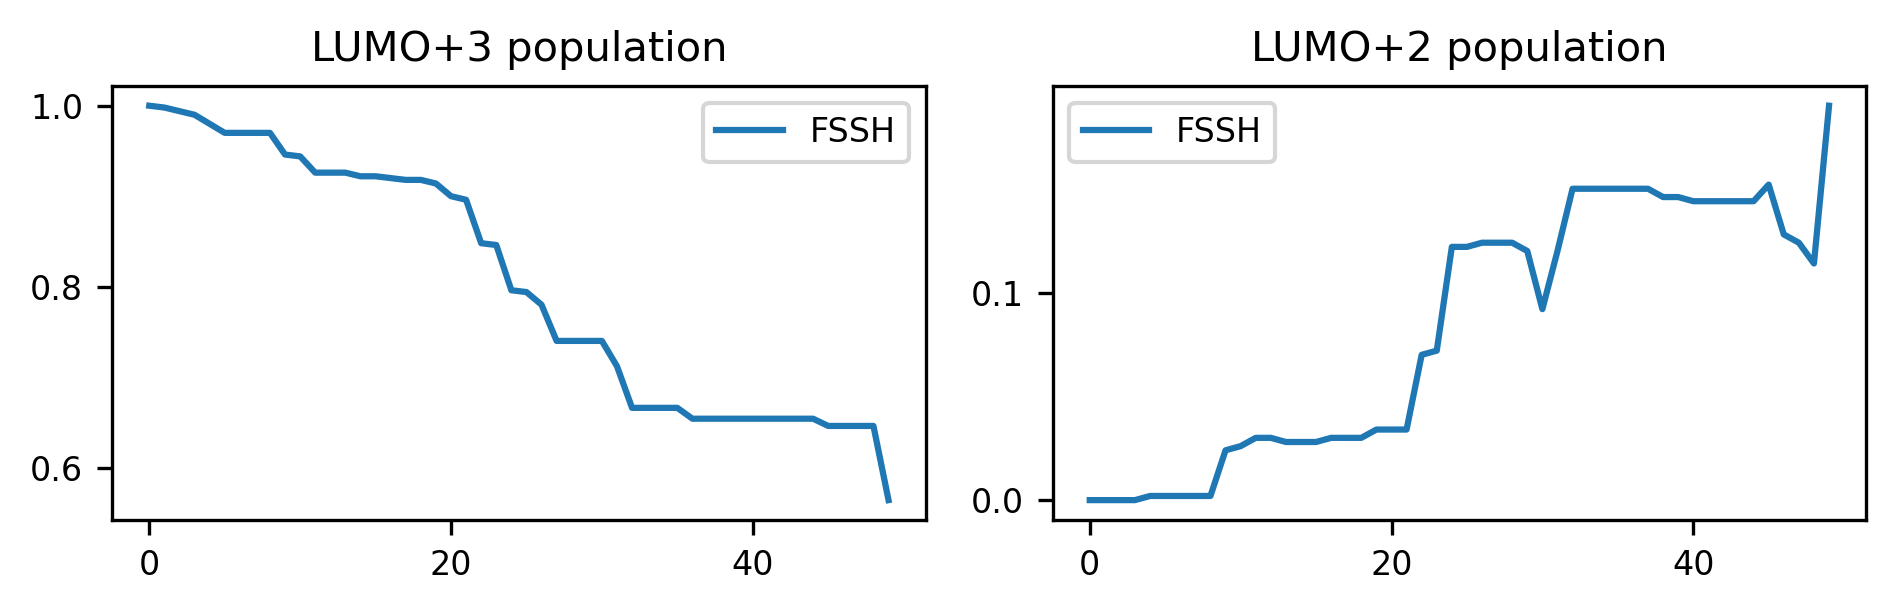

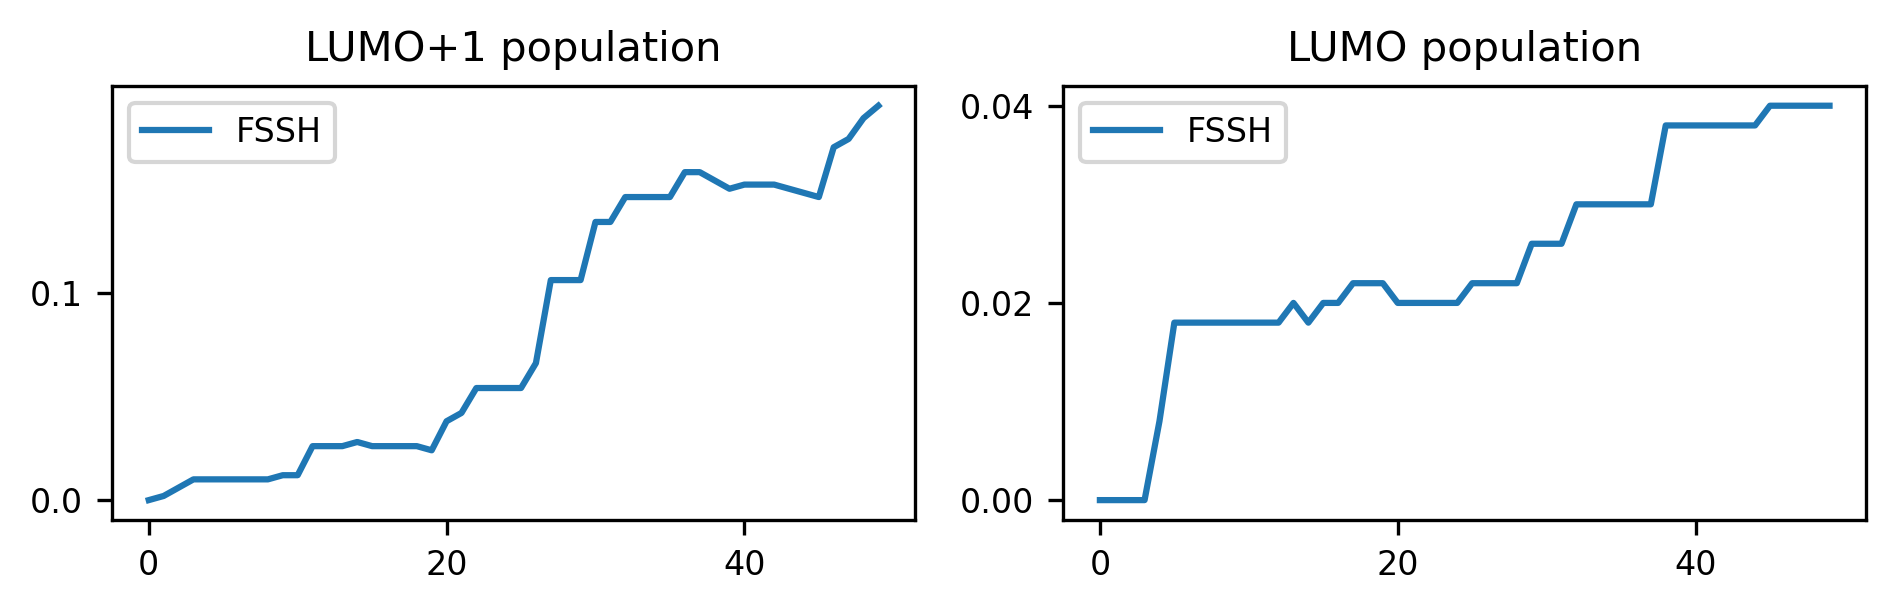

In [14]:
ks_lumo_population     = data_conv.unpack2(res_istate_lumo_p_3, 6)
ks_lumo_p_1_population = data_conv.unpack2(res_istate_lumo_p_3, 9)
ks_lumo_p_2_population = data_conv.unpack2(res_istate_lumo_p_3, 12)
ks_lumo_p_3_population = data_conv.unpack2(res_istate_lumo_p_3, 15)

ks_md_time = [ t for t in range(res_istate_lumo_p_3.num_of_rows) ]

xdata  = [ [ks_md_time], [ks_md_time] ]
ydata  = [ [ks_lumo_p_3_population], [ks_lumo_p_2_population] ]
titles = ['LUMO+3 population', 'LUMO+2 population']
labels = [ ['FSSH'] ]
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, num_subplots=2, 
                              titles=titles, labels=labels, title_size=10, xticks_size=8,
                              yticks_size=8, n_superimposing=1 )

xdata  = [ [ks_md_time], [ks_md_time] ]
ydata  = [ [ks_lumo_p_1_population], [ks_lumo_population] ]
titles = ['LUMO+1 population', 'LUMO population']

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, num_subplots=2,
                              titles=titles, labels=labels, title_size=10, xticks_size=8, 
                              yticks_size=8, n_superimposing=1 )


### 4.2. Decoherence methods<a name="decoherence_cooling"></a>
[Return to Table of contents](#toc)

Now, we considered other decoherence_methods. To use the IDA [1] decoherence method, set arams["decoherence_method"]=1. To use the mSDM [2] decoherence method, set params["decoherence_method"]=2. To use the DISH [3] decoherence method, set params["decoherence_method"]=3. Herein, we consider all 3 cases.

In [15]:
start = time.time()

params["decoherence_method"] = 1
res_ida_istate_lumo_p_3 = step4.run(hvib, params)
end = time.time()
print("Time to run IDA NBRA NAMD = ", end - start)

params["decoherence_method"] = 2
res_msdm_istate_lumo_p_3 = step4.run(hvib, params)
end = time.time()
print("Time to run mSDM NBRA NAMD = ", end - start)


params["decoherence_method"] = 3
res_dish_istate_lumo_p_3 = step4.run(hvib, params)
end = time.time()
print("Time to run DISH NBRA NAMD = ", end - start)


Time to run IDA NBRA NAMD =  1.0191497802734375
Time to run mSDM NBRA NAMD =  1.9713010787963867
Time to run DISH NBRA NAMD =  2.9916744232177734


We now plot the IDA, mSDM, and DISH decoherence cases in the same way in which we plotting the results for the case of no decoherence (FSSH)


You do not have a labels for every subplot. Assigning labels[0] to all subplots


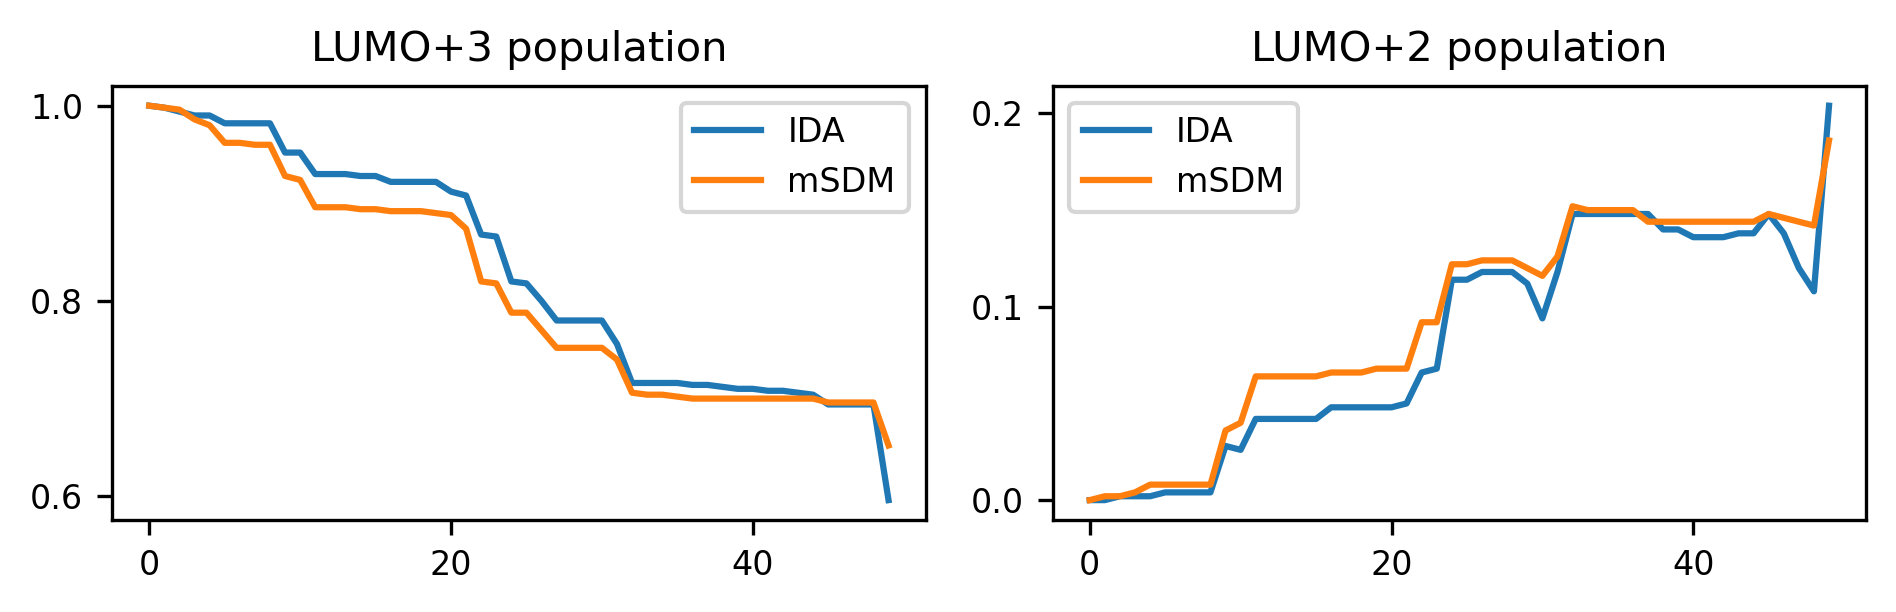

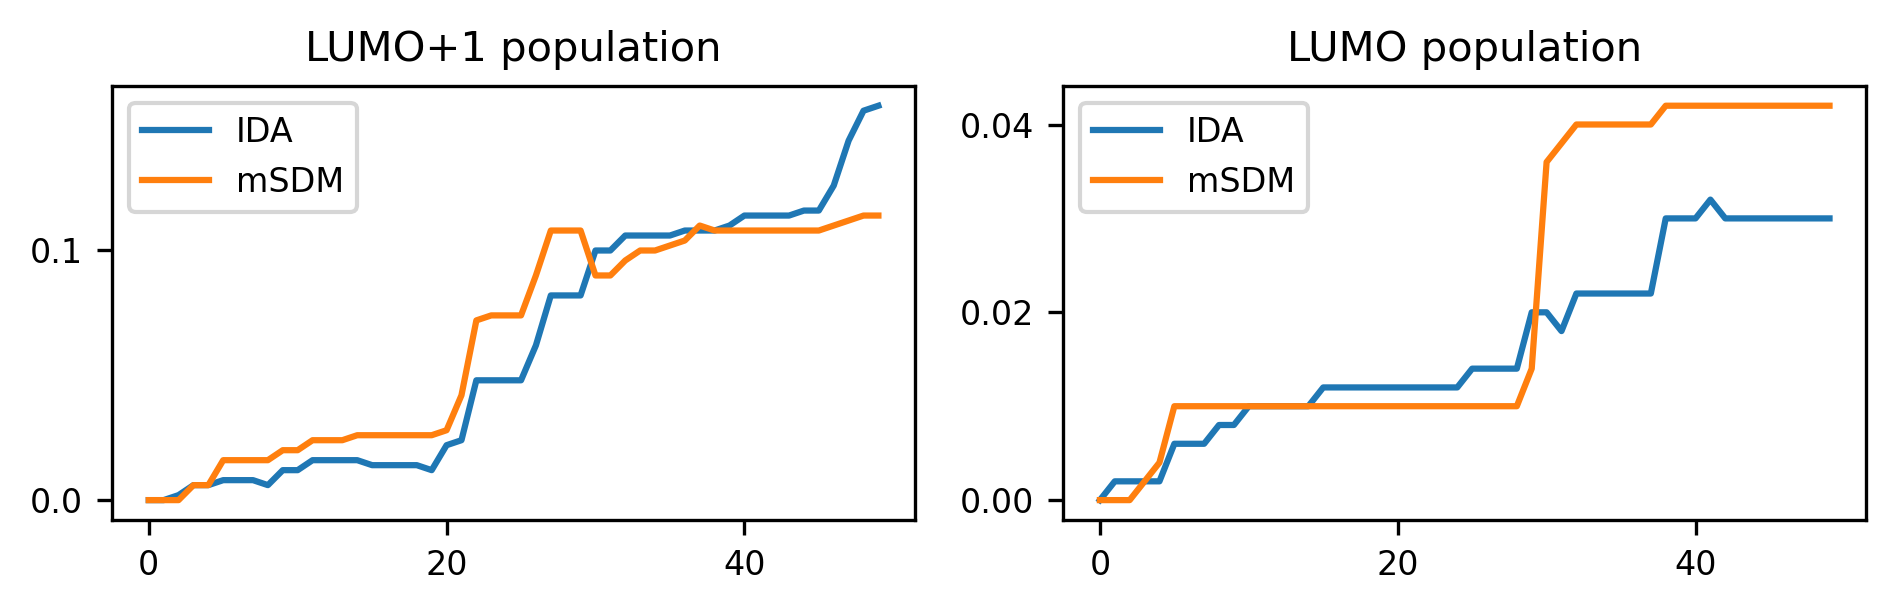

In [16]:
ks_ida_lumo_population     = data_conv.unpack2(res_ida_istate_lumo_p_3, 6)
ks_ida_lumo_p_1_population = data_conv.unpack2(res_ida_istate_lumo_p_3, 9)
ks_ida_lumo_p_2_population = data_conv.unpack2(res_ida_istate_lumo_p_3, 12)
ks_ida_lumo_p_3_population = data_conv.unpack2(res_ida_istate_lumo_p_3, 15)

ks_msdm_lumo_population     = data_conv.unpack2(res_msdm_istate_lumo_p_3, 6)
ks_msdm_lumo_p_1_population = data_conv.unpack2(res_msdm_istate_lumo_p_3, 9)
ks_msdm_lumo_p_2_population = data_conv.unpack2(res_msdm_istate_lumo_p_3, 12)
ks_msdm_lumo_p_3_population = data_conv.unpack2(res_msdm_istate_lumo_p_3, 15)

ks_dish_lumo_population     = data_conv.unpack2(res_msdm_istate_lumo_p_3, 6)
ks_dish_lumo_p_1_population = data_conv.unpack2(res_msdm_istate_lumo_p_3, 9)
ks_dish_lumo_p_2_population = data_conv.unpack2(res_msdm_istate_lumo_p_3, 12)
ks_dish_lumo_p_3_population = data_conv.unpack2(res_msdm_istate_lumo_p_3, 15)


xdata  = [ [ks_md_time], [ks_md_time] ]
ydata  = [ [ks_ida_lumo_p_3_population, ks_msdm_lumo_p_3_population],
           [ks_ida_lumo_p_2_population, ks_msdm_lumo_p_2_population], 
         ]
labels = [ ["IDA", "mSDM"] ]
titles = ['LUMO+3 population', 'LUMO+2 population']
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, 
                              num_subplots=2, colors=["green", "purple"], 
                              titles=titles, labels=labels, title_size=10, xticks_size=8, 
                              yticks_size=8, n_superimposing=2 )


ydata  = [ [ks_ida_lumo_p_1_population, ks_msdm_lumo_p_1_population, ks_dish_lumo_p_1_population], 
           [ks_ida_lumo_population, ks_msdm_lumo_population, ks_dish_lumo_population], 
         ]
titles = ['LUMO+1 population', 'LUMO population']
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, 
                              num_subplots=2, colors=["green, purple, orange"], 
                              titles=titles, labels=labels, title_size=10, xticks_size=8,                             
                              yticks_size=8, n_superimposing=2 )



### 4.3.  BLLZ NAMD<a name="bllz"></a>
[Return to Table of contents](#toc)

to determine the hopes based on energy gaps and time derivative of energy gap at the min. So during the several trajectories 
where the energy gap reaches the min, we should numerically calculate time derivative. so we can compute the hopping probabolity. It is LZ module. 

One can also do the dynamics using only the energies. This is what is done in the NBRA variant of the BLLZ [4] namd method. The setup for the performing NAMD using the BL-LZ NAMD method is shown below. Here, we give a breif overview of the new parameters appearing here:

`params["target_space"]` - set to 1 to allow nonadiabatic transitions between all electronic states. 0 to allow only between adjacent electron states

`params["gap_min_exception"]` - option to handle the situation when extrapolated gap minimum is negative. 0 corresponds to setting the energy gap to zero when the extrapolated energy gap is negative. 1 uses the mid-point gap.

`params["Boltz_opt_BL"]` - The option to select a probability of hopping acceptance. This is the same as in the other NBRA cases. 0 - all proposed hops are accepted - no rejection based on energies. 1 - proposed hops are accepted with exp(-E/kT) probability - the old (hence the default approach). 2 - proposed hops are accepted with the probability derived from Maxwell-Boltzmann distribution

`params["evolve_Markov"]` - whether to propagate the "SE" populations via Markov chain

`params["evolve_TSH"]` - whether to propagate the "SH" populations via TSH with many trajectories

The BLLZ NAMD is run by calling the function lz.run(hvib, params). This funciton also takes as arguments the vibronic hamiltonian and a parameters dictionary. 

In [17]:
#"""
#========================================================
# Looking on the "SE" populations - Markov chain approach
params["target_space"]       = 1
params["gap_min_exception"]  = 0
params["Boltz_opt_BL"]       = 1                      # Option to incorporate hte frustrated hops into BL probabilities
params["outfile"]            = "_out_BLLZ_NBRA_NAMD.txt" # output file
params["evolve_Markov"]      = True                   # Rely on the Markov approach
params["evolve_TSH"]         = False                  # don't care about TSH
params["ntraj"]              = 1                      # how many stochastic trajectories # 1 is enough because we dont need hopping here
params["istate"]             = 4                      # from 0

start = time.time()
res_bllz, P = lz.run(hvib, params)
end = time.time()
print("Time to run BL-LZ = ", end - start)


Time to run BL-LZ =  0.11655783653259277


We also plot the nonadiabatic dynamics in a similar fashion to the FSSH case


You do not have a labels for every subplot. Assigning labels[0] to all subplots

You do not have a labels for every subplot. Assigning labels[0] to all subplots


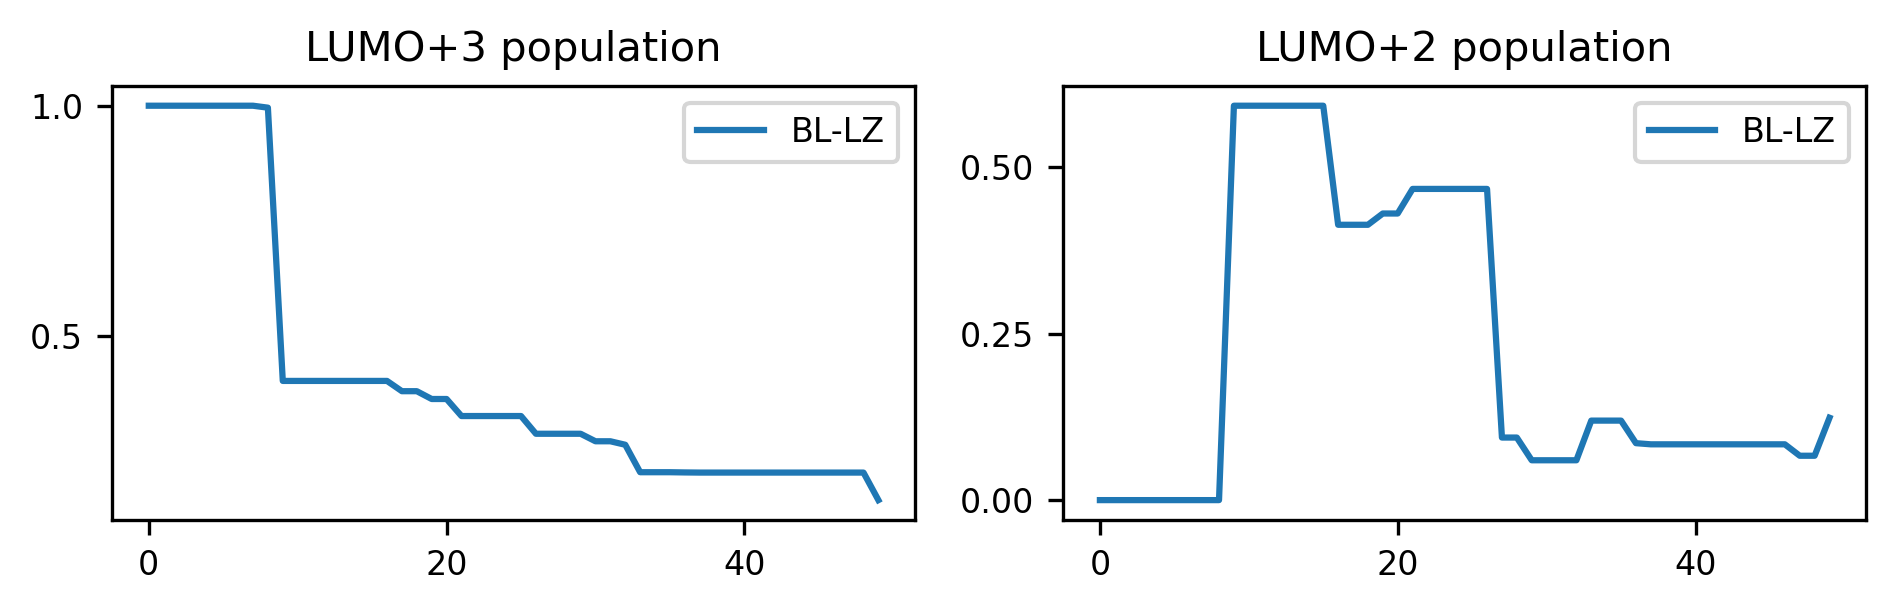

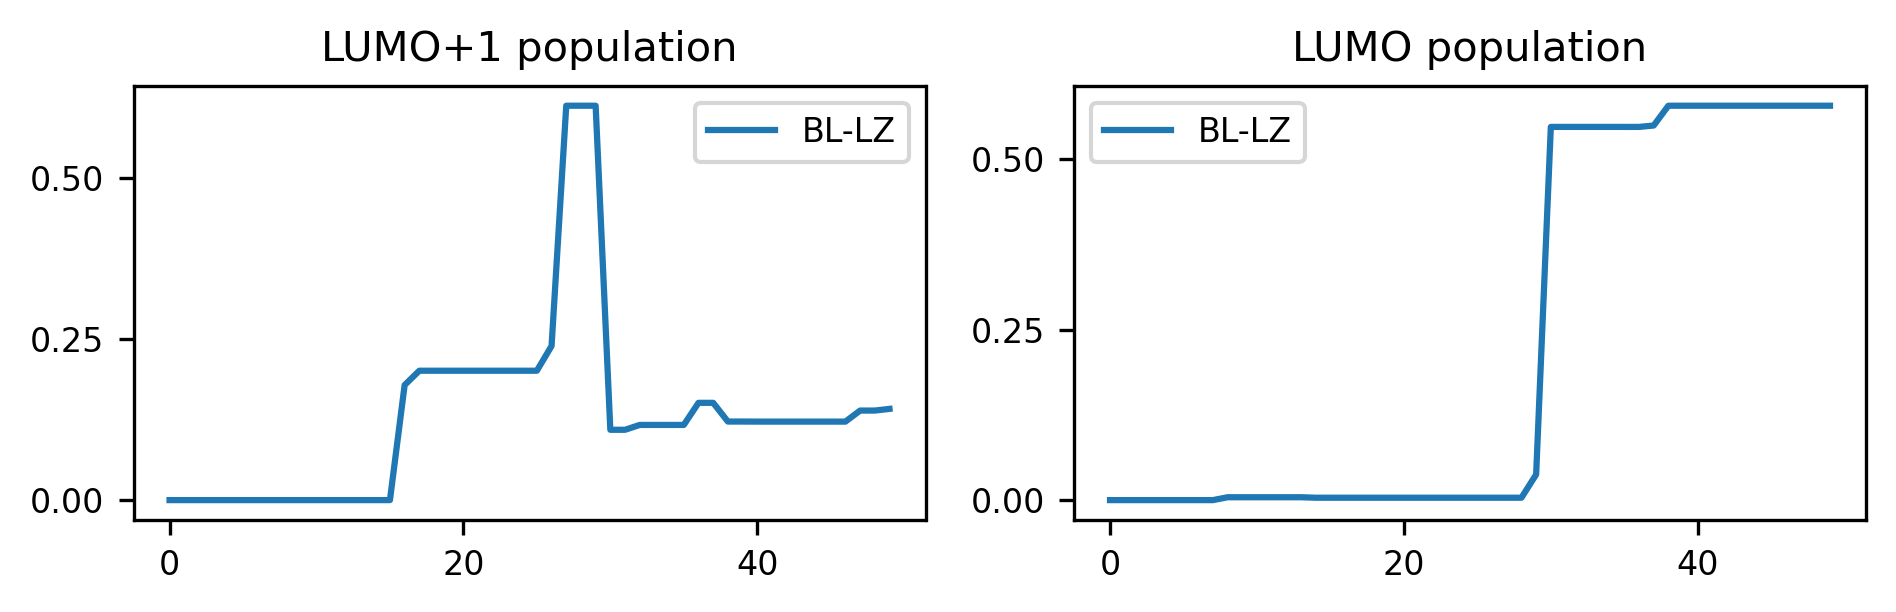

In [18]:
ks_time_dependent_energies = []

ks_bllz_lumo_population     = data_conv.unpack2(res_bllz, 5)
ks_bllz_lumo_p_1_population = data_conv.unpack2(res_bllz, 8)
ks_bllz_lumo_p_2_population = data_conv.unpack2(res_bllz, 11)
ks_bllz_lumo_p_3_population = data_conv.unpack2(res_bllz, 14)


xdata  = [ [ks_md_time], [ks_md_time] ]
ydata  = [ [ks_bllz_lumo_p_3_population], [ks_bllz_lumo_p_2_population] ]
titles = ['LUMO+3 population', 'LUMO+2 population']
labels = [ ["BL-LZ"] ]
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, num_subplots=2,
                              titles=titles, labels=labels, title_size=10, xticks_size=8, yticks_size=8, 
                              n_superimposing=1 )

xdata  = [ [ks_md_time], [ks_md_time] ]
ydata  = [ [ks_bllz_lumo_p_1_population], [ks_bllz_lumo_population] ]
titles = ['LUMO+1 population', 'LUMO population']
labels = [ ["BL-LZ"] ]
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, num_subplots=2,
                              titles=titles, labels=labels, title_size=10, xticks_size=8, yticks_size=8, 
                              n_superimposing=1 )


### 4.4. Comparative analysis

Now, lets combine all the methods the FSSH, IDA, mSDM, DISH, and BLLZ approaches in a single plot yields:


You do not have a labels for every subplot. Assigning labels[0] to all subplots


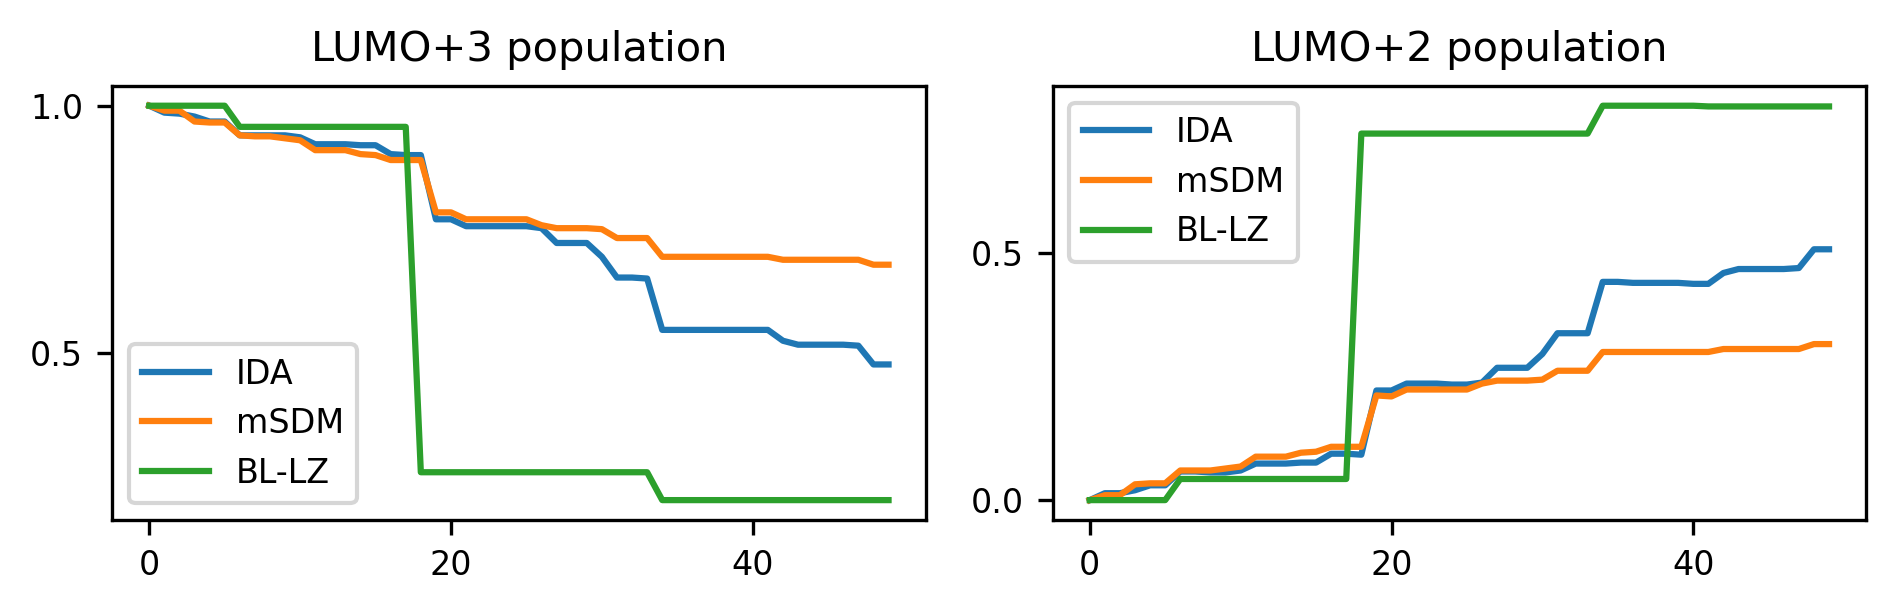

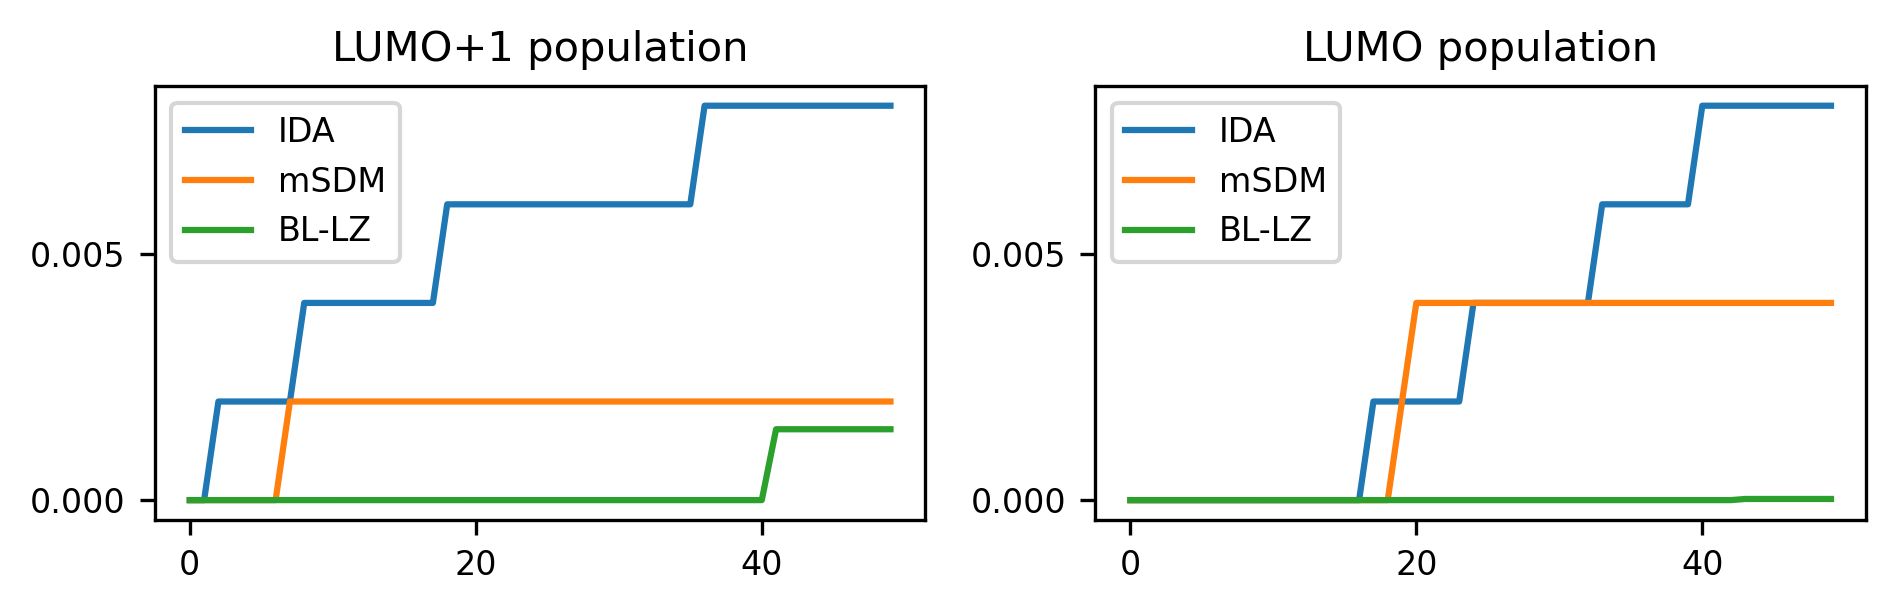

In [15]:
xdata  = [ [ks_md_time], [ks_md_time] ]
ydata  = [ 
           [ks_ida_lumo_p_3_population, ks_msdm_lumo_p_3_population, ks_bllz_lumo_p_3_population],
           [ks_ida_lumo_p_2_population, ks_msdm_lumo_p_2_population, ks_bllz_lumo_p_2_population],
         ]

labels = [ ["IDA", "mSDM", "BL-LZ"] ]
titles = ['LUMO+3 population', 'LUMO+2 population']
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, num_subplots=2,
                              colors=["green, purple, red"], titles=titles, labels=labels,
                              title_size=10, xticks_size=8, yticks_size=8, n_superimposing=3 )

ydata  = [ 
           [ks_ida_lumo_p_1_population, ks_msdm_lumo_p_1_population, ks_bllz_lumo_p_1_population],
           [ks_ida_lumo_population, ks_msdm_lumo_population, ks_bllz_lumo_population],
         ]

titles = ['LUMO+1 population', 'LUMO population']
data_visualize.plot_nparrays( plt, xdata, ydata, fig_width=6.42, fig_height=2.14, num_subplots=2,
                              colors=["green, purple, red"], titles=titles, labels=labels,
                              title_size=10, xticks_size=8, yticks_size=8, n_superimposing=3 )


### Exercise 1<a name="exercise1"></a>
[Return to TOC](#toc)

What do you make of the dynamics? How do the wavefunction-based approaches compare to the BLLZ (energy only) case? Why do you think the DISH yield the slowest dynamics?

# 5. LUMO-HOMO transition<a name="lh"></a>
[Return to TOC](#toc)

To simulate the nonradiative electorn-hole recominbation, we set the initial state to be VBM, and watch the CBM, VBm, and VBM+1 populations. We use NBRA FSSH in this example. 

In [16]:
start = time.time()
params["decoherence_method"] = 0
params["istate"] = 1
res_fssh_istate_lumo = step4.run(hvib, params)
end = time.time()

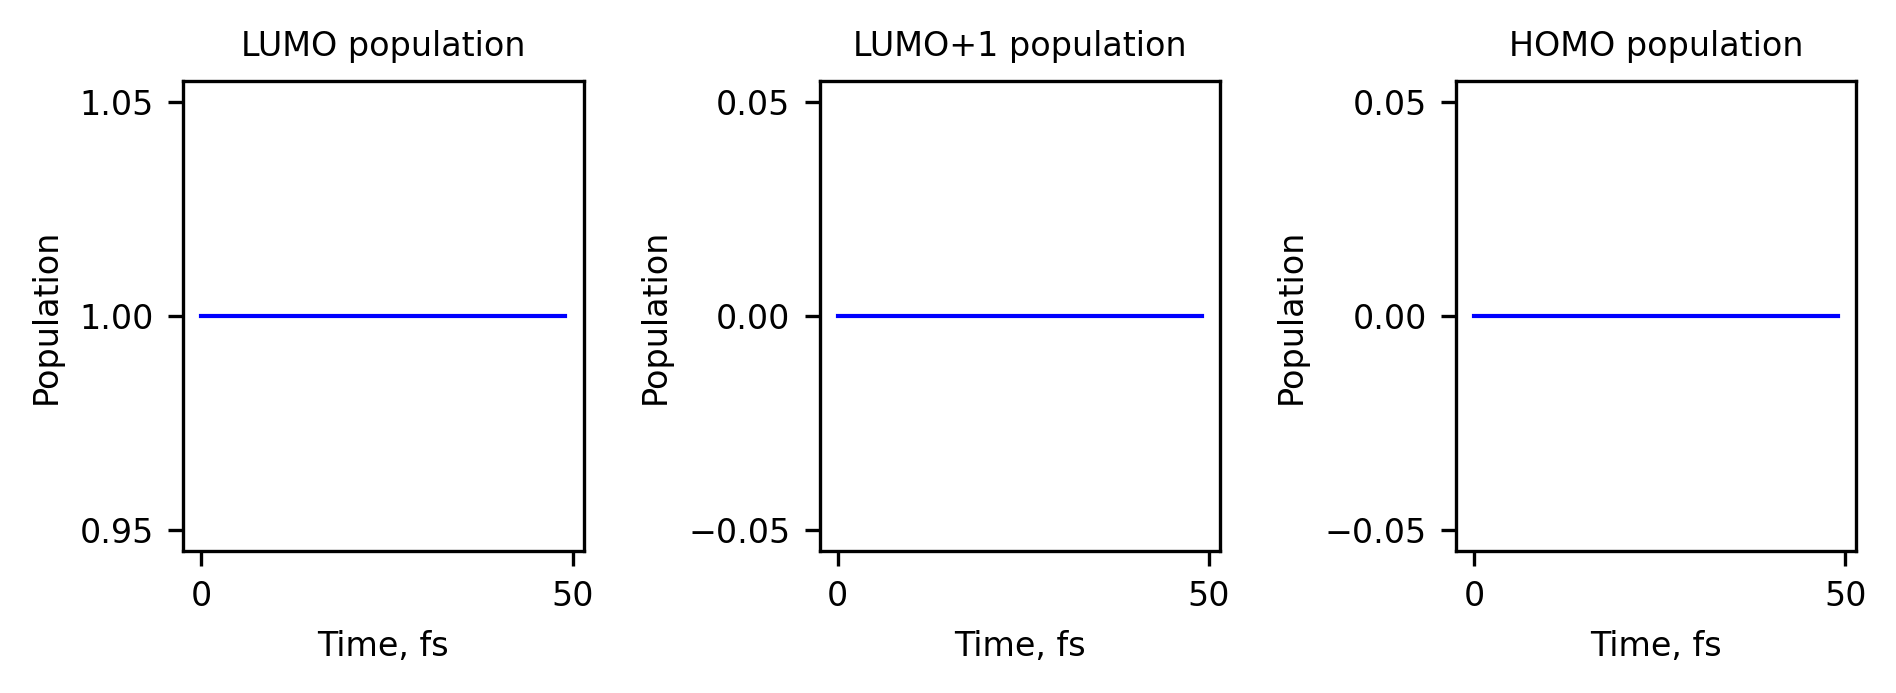

In [17]:
ks_time_dependent_energies = []

ks_fssh_homo_population     = data_conv.unpack2(res_fssh_istate_lumo, 3)
ks_fssh_lumo_population     = data_conv.unpack2(res_fssh_istate_lumo, 6)
ks_fssh_lumo_p_1_population = data_conv.unpack2(res_fssh_istate_lumo, 9)
ks_md_time = [ t for t in range(res_fssh_istate_lumo.num_of_rows) ]

plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,3,1)
plt.title('LUMO population', fontsize=8)
plt.xlabel('Time, fs',fontsize=8)
plt.ylabel('Population',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot(ks_md_time, ks_fssh_lumo_population, label="", linewidth=1, color = "blue")

plt.subplot(1,3,2)
plt.title('LUMO+1 population', fontsize=8)
plt.xlabel('Time, fs',fontsize=8)
plt.ylabel('Population',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot(ks_md_time, ks_fssh_lumo_p_1_population, label="", linewidth=1, color = "blue")

plt.subplot(1,3,3)
plt.title('HOMO population', fontsize=8)
plt.xlabel('Time, fs',fontsize=8)
plt.ylabel('Population',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot(ks_md_time, ks_fssh_homo_population, label="", linewidth=1, color = "blue")
plt.tight_layout()

### Exercise 2<a name="exercise2"></a>
[Return to TOC](#toc)

The left figure titles "LUMO" population, shows no decay. Please provide 1-2 reasons on why might this be.


## 6. References<a name="references"></a>
[Return to TOC](#toc)

[1] 	Nelson, T.; Fernandez-Alberti, S.; Roitberg, A. E.; Tretiak, S. Nonadiabatic Excited-State Molecular Dynamics: Treatment of Electronic Decoherence. J. Chem. Phys. 2013, 138 (22), 224111.

[2] 	Smith, B.; Akimov, A. V. A Comparative Analysis of Surface Hopping Acceptance and Decoherence Algorithms within the Neglect of Back-Reaction Approximation. J. Chem. Phys. 2019, 151 (12), 124107.

[3] 	Jaeger, H. M.; Fischer, S.; Prezhdo, O. V. Decoherence-Induced Surface Hopping. J. Chem. Phys. 2012, 137 (22), 22A545.

[4] 	Smith, B.; Akimov, A. V. Hot Electron Cooling in Silicon Nanoclusters via Landau–Zener Nonadiabatic Molecular Dynamics: Size Dependence and Role of Surface Termination. J. Phys. Chem. Lett. 2020, 11 (4), 1456–1465.